In [30]:
%pylab notebook

# Run on CPU not GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras import layers

from primo.models.cas9_keras import log10_crispr_spec

import primo.models
import primo.datasets
import primo.tools.filepath as filepaths
import primo.tools.sequences as seqtools
import pandas as pd


Populating the interactive namespace from numpy and matplotlib


In [46]:
# Load the model to be examined
# encoder_20 = tf.keras.models.load_model('/tf/primo/data/models/encoder_singlesite_model.h5')
encoder_20 = tf.keras.models.load_model('/tf/primo/data/models/encoder_1site_model_20220614.h5')
# encoder_20 = tf.keras.models.load_model('/tf/primo/data/models/encoder_1site_model_20220615.h5')

# encoder_80 = tf.keras.models.load_model('/tf/primo/data/models/encoder_4site_model.h5')
encoder_80 = tf.keras.models.load_model('/tf/primo/data/models/encoder_4site_model_20220630.h5')
# encoder_80 = tf.keras.models.load_model('/tf/primo/data/models/encoder_4site_model_20220701.h5')

encoder_20.compile()
encoder_80.compile()

In [47]:
### 
# Define utilities
###
def make_multisite_predictor(predictor):
    """Return a function that will predict multiple sites using the predictor
    function provided to score each
    
    Combined probability is 1 - (1 - P(site1)) * (1 - P(site2)) ... * (1 - P(siteN))
    """
    def multisite_predict(seq_pairs):
        n_sites = int(seq_pairs.shape[2] / 20)
        # Split into separate sites
        sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
        # Apply predictor to sites independently
        scores = tf.map_fn(tf.function(predictor), sites)
        #scores *= tf.sqrt(tf.reduce_mean(tf.reduce_max(seq_pairs, axis=-1)))
        # Compute combined probability|
        #return tf.reduce_max(scores, axis=0)
        #return 2 * (tf.sigmoid(3*tf.sqrt(tf.reduce_sum(scores, axis=0))) - 0.5)
        return 1 - tf.reduce_prod(1 - scores, axis=0)
    return multisite_predict

def log_multisite_predictor(seq_pairs):
    n_sites = int(seq_pairs.shape[2] / 20)
    # Split into separate sites
    sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
    # Apply predictor to sites independently
    scores = tf.map_fn(tf.function(log10_crispr_spec), sites)
    linear_scores = 10**scores
    return tf.experimental.numpy.log10(tf.reduce_sum(linear_scores, axis=0))

def confidence_by_base(sequences):
    """Takes a batch of softmax sequences, and returns vector of average confidence in each position
    
    sequences: Number of exmaple x Number of bases x 4
    
    Returns: 1 x number of bases
    """
    # reduce last dimension to max base number
    return np.mean(np.max(sequences, axis=-1), axis=0)

def entropy_by_base(sequences):
    x = np.sum(sequences, axis=0)
    x /= np.sum(x, axis=1)[:, None]
    entropy = -np.sum(x * np.log(x + 1e-10), axis=1)
    return entropy

def base_distribution(sequences):
    one_hots = one_hot(sequences)
    bases = np.sum(one_hots, axis=0)

def one_hot(nparray, depth = 0, on_value = 1, off_value = 0):
    if depth == 0:
        depth = np.max(nparray) + 1
    assert np.max(nparray) < depth, "the max index of nparray: {} is larger than depth: {}".format(np.max(nparray), depth)
    shape = nparray.shape
    out = np.ones((*shape, depth), dtype=np.float32) * off_value
    indices = []
    for i in range(nparray.ndim):
        tiles = [1] * nparray.ndim
        s = [1] * nparray.ndim
        s[i] = -1
        r = np.arange(shape[i]).reshape(s)
        if i > 0:
            tiles[i-1] = shape[i-1]
            r = np.tile(r, tiles)
        indices.append(r)
    indices.append(nparray)
    out[tuple(indices)] = on_value
    return out

def get_multiple_batchs(n, generator):
    indices = None
    values = None
    for _ in range(n):
        i, v = next(generator)
        if indices is None:
            indices = i
            values = v
        else:
            indices = np.concatenate([indices, i])
            values = np.concatenate([values, v])
    return indices, values

In [48]:
###
# Load queries and see what they encode to
###
query_features_filepath = filepaths.get_query_features_path(isDocker=True)
query_features = pd.read_hdf(query_features_filepath)
query_seqs = seqtools.onehots_to_seqs(encoder_20.predict(query_features))
print(f"Query Seqs: \n" + "\n".join(query_seqs))

def seq_str_to_input(seq):
    return np.transpose(seqtools.seqs_to_onehots(seq), [1, 0, 2])

query_features_filepath = filepaths.get_query_features_path(isDocker=True)
query_features = pd.read_hdf(query_features_filepath)
query_seqs = seqtools.onehots_to_seqs(encoder_80.predict(query_features))
print(f"Query Seqs: \n" + "\n".join(query_seqs))

def seq_str_to_input(seq):
    return np.transpose(seqtools.seqs_to_onehots(seq), [1, 0, 2])

Query Seqs: 
ACCGGTAAGGCACAGAAACG
ACCTGTAAGGCACAGAAACG
ATTTGCAAGGAACAAAAACG
Query Seqs: 
CCTTGAATCTAACACACGGAAACGGGAGCTGGTAAGCGTGAACGTAGCGCCCAGGCAGATATCCAATGTAAGAGAGTACG
CCTTGAATACCAGTGATGAAAACGGGAGCTGGTAAGCGTGACAGGATCGCCCAAGTAATTTTCCAGCGTAGGCGAGTAGG
CCGGAAGTTTATGTGATGAAACGCAAAGATGGTAAGCGTGTAATGCCCTCGAAAGCAGATTTTCAGTGTAGACGATAAGG


In [49]:
###
# Use data batch generators to get a batch of random training and validation
# data

def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    while True:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar
        
batch_size = 200
similarity_threshold = 75

validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

# Generators for balanced pairs
val_pair_generator = keras_batch_generator(
    validation_dataset.balanced_pairs(batch_size, similarity_threshold), 
    similarity_threshold)

# Get pairs (50 batches x 200 batch size = 10k pairs)
val_feat_pairs, val_truth = get_multiple_batchs(50, val_pair_generator)


<IPython.core.display.Javascript object>


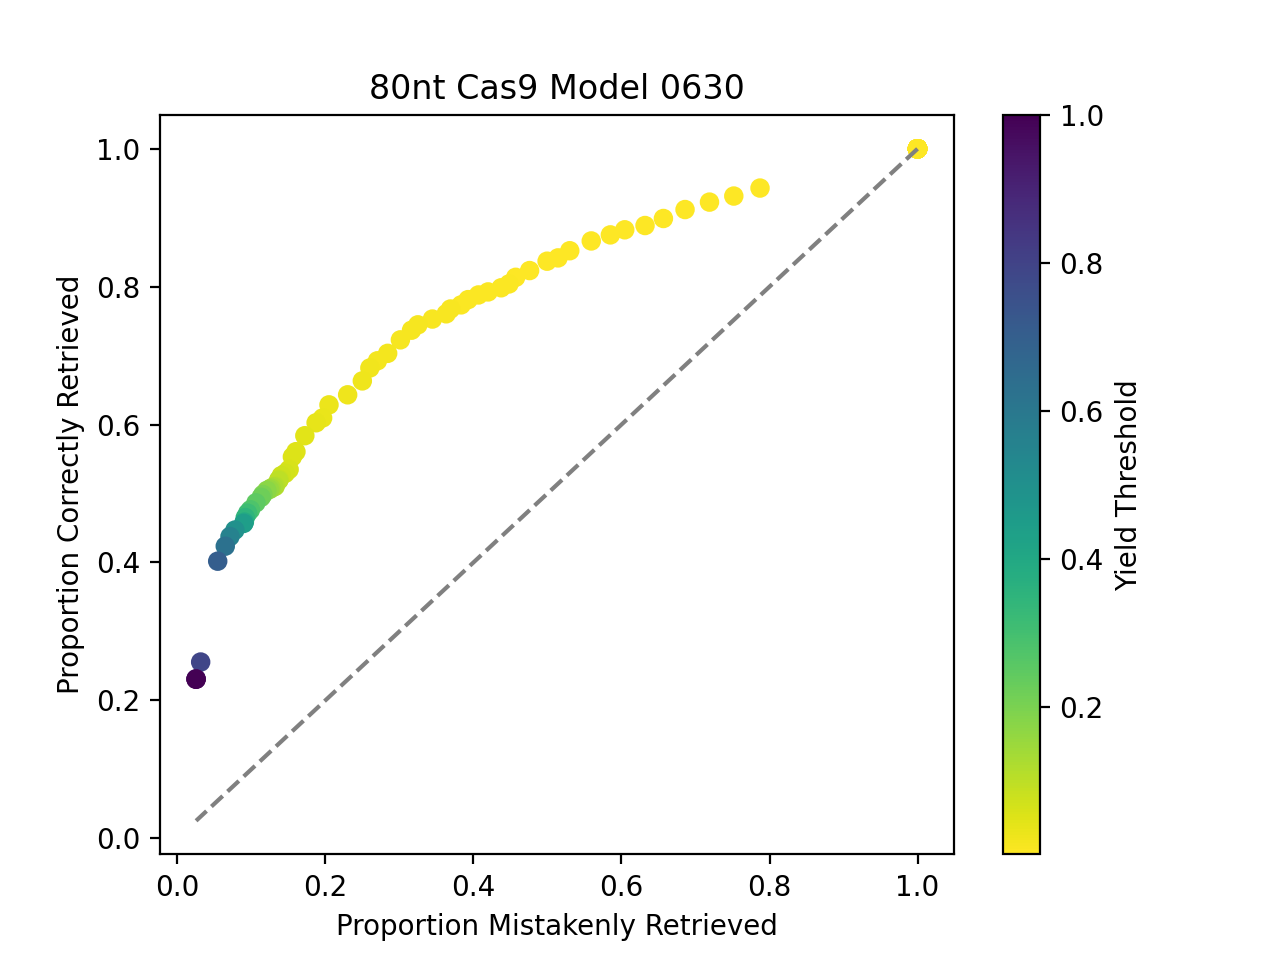

In [50]:
# Encode sequence pairs with the 1 site, 20 nt cas9 encoder
# val_seq_pairs = one_hot(np.stack([
#     encoder_20.predict(val_feat_pairs[:, 0, :]).argmax(-1),
#     encoder_20.predict(val_feat_pairs[:, 1, :]).argmax(-1),
# ], axis=1)).astype(np.float32)

# Encode sequence pairs with the 4 site, 80 nt cas9 encoder
val_seq_pairs = one_hot(np.stack([
    encoder_80.predict(val_feat_pairs[:, 0, :]).argmax(-1),
    encoder_80.predict(val_feat_pairs[:, 1, :]).argmax(-1),
], axis=1)).astype(np.float32)


# split pairs into positive (similar) and negative (dissimilar) pairs
pairs_p = val_seq_pairs[val_truth > 0.5] #onehot vectors similar
pairs_n = val_seq_pairs[val_truth < 0.5] #onehot vectors dissimilar


# Compute the log10 scores for positive (similar) and negative (dissimilar) pairs
# modify each value with 10**n to scale between 0 and 1
Yp_yield = 10**(log_multisite_predictor(pairs_p).numpy())
Yn_yield = 10**(log_multisite_predictor(pairs_n).numpy())

recall_data = []
false_positive_data = []

# thresholds=np.linspace(0, 1, 100)
# thresholds=np.logspace(-5, 0, 100)
# for cas80
thresholds = [1e-05, 1.1233240329780266e-05, 1.2618568830660211e-05, 1.4174741629268048e-05, 1.5922827933410938e-05, 1.788649529057435e-05, 2.0092330025650458e-05, 2.2570197196339216e-05, 2.5353644939701114e-05, 2.848035868435799e-05, 3.199267137797385e-05, 3.5938136638046256e-05, 4.037017258596558e-05, 4.534878508128582e-05, 5.0941380148163754e-05, 5.72236765935022e-05, 6.428073117284319e-05, 7.220809018385456e-05, 8.111308307896872e-05, 9.111627561154887e-05, 0.00010235310218990269, 0.00011497569953977356, 0.0001291549665014884, 0.000145082877849594, 0.00016297508346206434, 0.0001830738280295368, 0.00020565123083486514, 0.0002310129700083158, 0.00025950242113997375, 0.0002915053062825176, 0.00032745491628777284, 0.0003678379771828634, 0.00041320124001153346, 0.0004641588833612782, 0.0005214008287999684, 0.0005857020818056667, 0.0006579332246575682, 0.0007390722033525775, 0.0008302175681319744, 0.0009326033468832199, 0.001047615752789665, 0.0011768119524349979, 0.0013219411484660286, 0.001484968262254465, 0.0016681005372000592, 0.001873817422860383, 0.00210490414451202, 0.002364489412645407, 0.0026560877829466868, 0.0029836472402833404, 0.003351602650938841, 0.0037649358067924675, 0.0042292428743894986, 0.0047508101621027985, 0.005336699231206307, 0.005994842503189409, 0.006734150657750821, 0.007564633275546291, 0.008497534359086439, 0.009545484566618337, 0.010722672220103232, 0.012045035402587823, 0.013530477745798061, 0.01519911082952933, 0.017073526474706904, 0.019179102616724886, 0.021544346900318846, 0.02420128264794381, 0.027185882427329403, 0.030538555088334154, 0.03430469286314919, 0.03853528593710527, 0.04328761281083057, 0.04862601580065353, 0.05462277217684343, 0.061359072734131694, 0.06892612104349695, 0.0774263682681127, 0.08697490026177834, 0.09770099572992247, 0.10974987654930568, 0.12328467394420659, 0.13848863713938717, 0.15556761439304723, 0.1747528400007683, 0.19630406500402725, 0.22051307399030456, 0.2477076355991709, 0.2782559402207126, 0.31257158496882353, 0.3511191734215127, 0.3944206059437656, 0.44306214575838776, 0.49770235643321137, 0.5590810182512223, 0.6280291441834247, 0.7054802310718645, 0.7924828983539169, 0.8902150854450392, 1.0, 1.0]


for t in thresholds:
    recall = (Yp_yield > t).mean()
    false_positive = (Yn_yield > t).mean()
    recall_data.append(recall)
    false_positive_data.append(false_positive)
    
plt.figure()   
plt.scatter(false_positive_data, recall_data, c=thresholds, cmap=plt.cm.viridis_r)
plt.plot(false_positive_data, false_positive_data, linestyle='dashed', color='grey')
plt.ylabel("Proportion Correctly Retrieved")
plt.xlabel("Proportion Mistakenly Retrieved")
plt.colorbar(label="Yield Threshold")
# plt.title("20nt Cas9 Model")
plt.title("80nt Cas9 Model 0630")
# plt.tight_layout()
# plt.savefig('20_cas9_retrieval_random_pair_simulations.png', bbox_inches='tight', dpi=1000)
plt.show()
# plt.savefig('80_cas9_retrieval_random_pair_simulationsjuly.png', bbox_inches='tight', dpi=1000)


In [51]:
print(list(recall_data))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9430569430569431, 0.9314685314685315, 0.9226773226773227, 0.9118881118881119, 0.8989010989010989, 0.8887112887112887, 0.8825174825174825, 0.8751248751248751, 0.8663336663336664, 0.8521478521478522, 0.8417582417582418, 0.836963036963037, 0.8233766233766234, 0.8135864135864136, 0.803996003996004, 0.7984015984015984, 0.7924075924075924, 0.788011988011988, 0.7812187812187812, 0.7736263736263737, 0.7676323676323676, 0.7606393606393607, 0.753046953046953, 0.7446553446553447, 0.7368631368631369, 0.7228771228771229, 0.7032967032967034, 0.6925074925074926, 0.6821178821178822, 0.6633366633366633, 0.6431568431568432, 0.6285714285714286, 0.6095904095904096, 0.6025974025974026, 0.5838161838161838, 0.5606393606393606, 0.5532467532467532, 0.5348651348651349, 0.5292707292707293, 0.5258741258741259, 0.52027972027

In [52]:
print(list(false_positive_data))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7871871871871872, 0.7517517517517518, 0.7189189189189189, 0.6858858858858858, 0.6566566566566566, 0.6318318318318318, 0.6044044044044043, 0.584984984984985, 0.5591591591591591, 0.5301301301301301, 0.5143143143143143, 0.4994994994994995, 0.4758758758758759, 0.45705705705705707, 0.44804804804804804, 0.43743743743743746, 0.4198198198198198, 0.4068068068068068, 0.3927927927927928, 0.3833833833833834, 0.36896896896896897, 0.36316316316316316, 0.34454454454454453, 0.3249249249249249, 0.3163163163163163, 0.3013013013013013, 0.2840840840840841, 0.2702702702702703, 0.26006006006006005, 0.24984984984984984, 0.23003003003003003, 0.2048048048048048, 0.1961961961961962, 0.1873873873873874, 0.17217217217217218, 0.16016016016016016, 0.15535535535535536, 0.15095095095095096, 0.14574574574574575, 0.14034034034034